In [455]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm
%matplotlib inline

In [456]:
train = pd.read_csv("train_clean.csv")

In [457]:
test = pd.read_csv('test_clean.csv')

In [459]:
# GrLivArea outliers
train = train.drop(train[(train['GrLivArea']>8.3) & (train['SalePrice']<300000)].index)

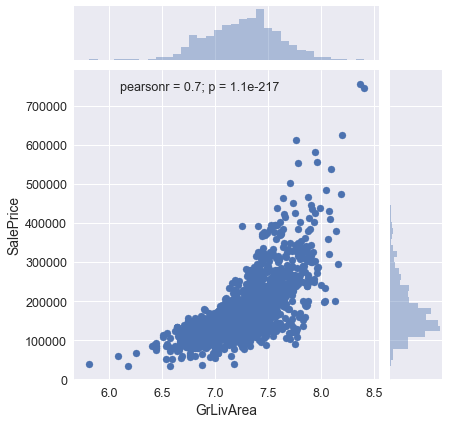

In [460]:
sns.jointplot(x ="GrLivArea", y="SalePrice", data=train)

In [461]:
from sklearn import preprocessing
from scipy.stats import boxcox

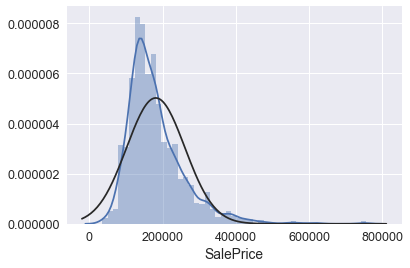

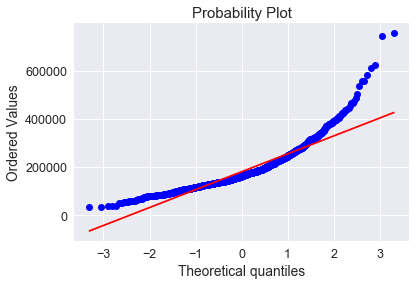

In [462]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [463]:
train["SalePrice"] = np.log1p(train["SalePrice"])

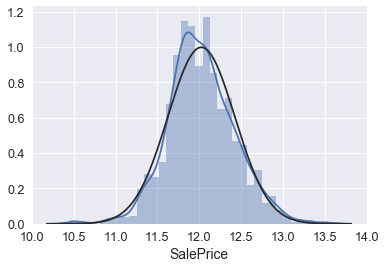

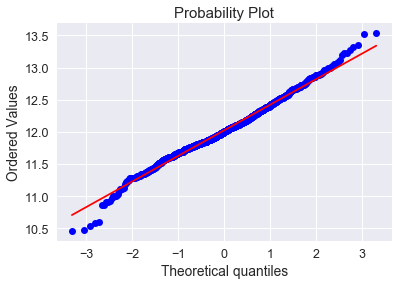

In [464]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [465]:
train['TotalSF'] = train['X1stFlrSF'] + train['X2ndFlrSF'] + train['TotalBsmtSF']
test['TotalSF'] = test['X1stFlrSF'] + test['X2ndFlrSF'] + test['TotalBsmtSF']

In [397]:
test.shape

(1459, 65)

In [398]:
train.shape

(1458, 66)

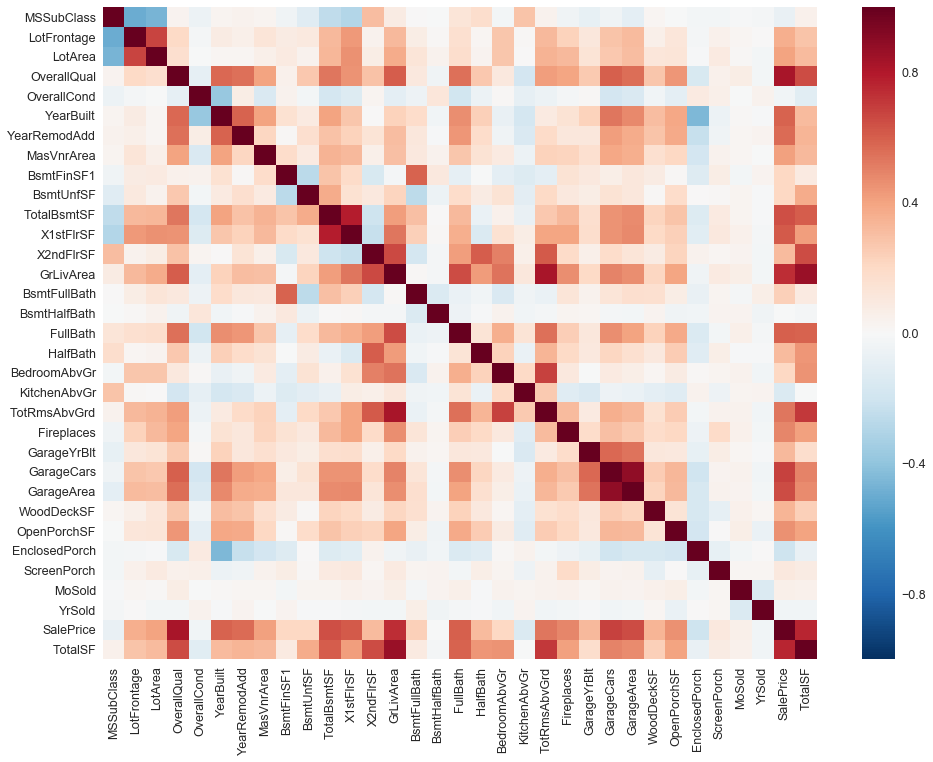

In [466]:
corr = train.corr()
ax = plt.subplots(figsize = (16,12))
sns.heatmap(corr)

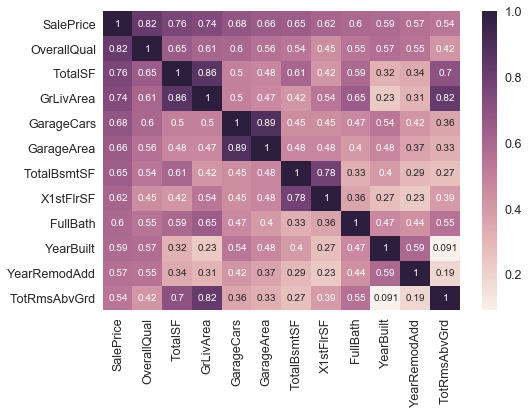

In [467]:
k = 12 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, annot=True, annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

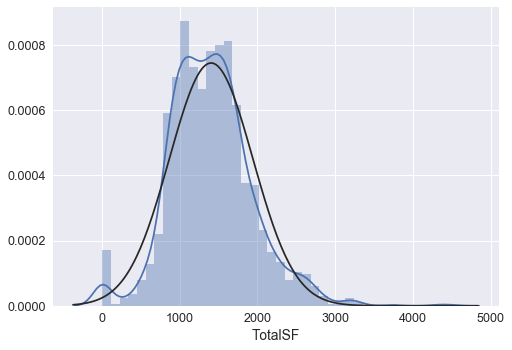

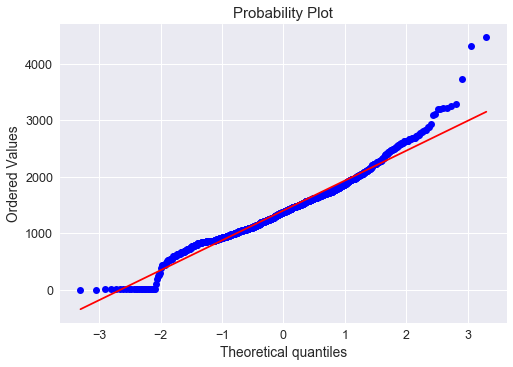

In [468]:
sns.distplot(train['TotalSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['TotalSF'], plot=plt)

ok, removing the one outlier where the total SF is higher than 7000 square feet

In [469]:
train = train.drop(train[train['TotalSF']>7000].index)

decided against boxcoxing it

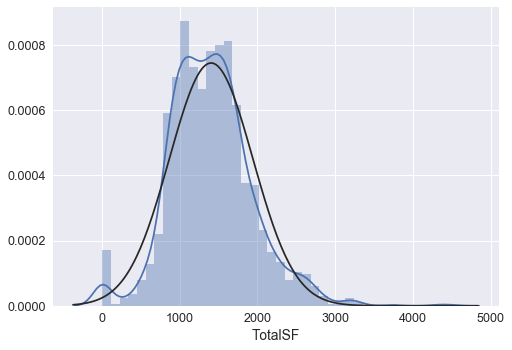

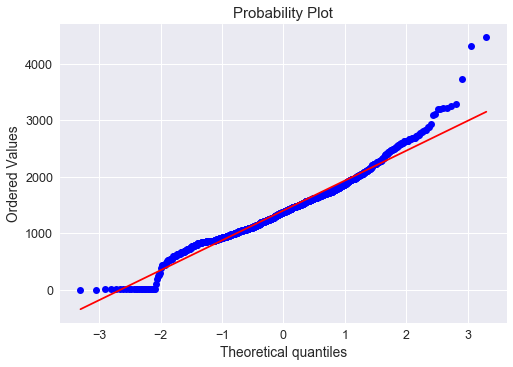

In [470]:
sns.distplot(train['TotalSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['TotalSF'], plot=plt)

In [405]:
y_train = train.SalePrice.values

In [406]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
data = pd.concat((train, test)).reset_index(drop=True)
data.drop(['SalePrice'], axis=1, inplace=True)
print("data size is : {}".format(data.shape))

data size is : (2917, 65)


In [407]:
train.drop(['SalePrice'], axis=1, inplace=True)

In [408]:
data = pd.get_dummies(data, drop_first=True, dummy_na=True)

In [409]:
train = data[:ntrain]
test = data[ntrain:]

In [410]:
train.shape

(1458, 250)

In [411]:
test.shape

(1459, 250)

In [412]:
# Load libraries
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [413]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [414]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.00099, random_state=1))

In [415]:
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Lasso score: 0.1144 (0.0063)


ok this one's a little worse than mine. but since this is what we decided i'll try working with it

In [416]:
lasso.fit(train.values, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.00099, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [417]:
final = lasso.predict(test)

In [418]:
final

array([  77.41650698,  110.71250101,  132.97321161, ...,  103.05384938,
         79.68961581,  160.57886993])

In [419]:
results = np.expm1(lasso.predict(test))

In [420]:
results

array([  4.18371210e+33,   1.20733632e+48,   5.61735720e+57, ...,
         5.69794331e+44,   4.06219169e+34,   5.47667691e+69])

In [447]:
test_ID = pd.read_csv('test_id.csv', header=None)

In [471]:
y_train

array([ 12.24769912,  12.10901644,  12.31717117, ...,  12.49313327,
        11.86446927,  11.90159023])

In [454]:
attempt3 = pd.DataFrame()
attempt3['Id'] = test_ID[1]
attempt3['SalePrice'] = results
attempt3.to_csv('submit3.csv', index=False)